## 0. 데이터 다운로드 주소
https://dacon.io/competitions/official/235713/data

경진대회의 목표는 신용카드 사용자 데이터를 보고 사용자의 대금 연체 정도를 예측하는 알고리즘을 구현하는 것.

타겟변수는 Credit이며, 평가지표는 Logloss로 계산함.

## 1. 필요한 패키지 로드

In [80]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

import glob

from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import random

## 2. 파일 불러오기

In [81]:
path = 'C:/Users/user/Desktop/16017005/creditcard'

In [82]:
import os
os.listdir(path)

['.ipynb_checkpoints',
 'catboost_info',
 'logs.log',
 'sample_submission.csv',
 'test.csv',
 'train.csv',
 'Untitled.ipynb']

In [83]:
train = pd.read_csv(path+'/train.csv',engine='python', index_col = 'index' )

In [84]:
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
index,,,,,,,,,,,,,,,,,,,
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0


In [85]:
test = pd.read_csv(path+'/test.csv',engine='python', index_col = 'index')

In [86]:
test

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
index,,,,,,,,,,,,,,,,,,
26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,2.0,-19.0
36453,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0,-34.0
36454,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,2.0,-55.0


## 3. 결측값 확인

In [87]:
train.isnull().any() #occyp_type에 결측값

gender           False
car              False
reality          False
child_num        False
income_total     False
income_type      False
edu_type         False
family_type      False
house_type       False
DAYS_BIRTH       False
DAYS_EMPLOYED    False
FLAG_MOBIL       False
work_phone       False
phone            False
email            False
occyp_type        True
family_size      False
begin_month      False
credit           False
dtype: bool

In [88]:
test.isnull().any() #occyp_type에 결측값

gender           False
car              False
reality          False
child_num        False
income_total     False
income_type      False
edu_type         False
family_type      False
house_type       False
DAYS_BIRTH       False
DAYS_EMPLOYED    False
FLAG_MOBIL       False
work_phone       False
phone            False
email            False
occyp_type        True
family_size      False
begin_month      False
dtype: bool

In [89]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  occyp_type     18286 non-null  object 
 16  family_size    26457 non-null  float64
 17  begin_month    26457 non-null  float64
 18  credit

In [90]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 26457 to 36456
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         10000 non-null  object 
 1   car            10000 non-null  object 
 2   reality        10000 non-null  object 
 3   child_num      10000 non-null  int64  
 4   income_total   10000 non-null  float64
 5   income_type    10000 non-null  object 
 6   edu_type       10000 non-null  object 
 7   family_type    10000 non-null  object 
 8   house_type     10000 non-null  object 
 9   DAYS_BIRTH     10000 non-null  int64  
 10  DAYS_EMPLOYED  10000 non-null  int64  
 11  FLAG_MOBIL     10000 non-null  int64  
 12  work_phone     10000 non-null  int64  
 13  phone          10000 non-null  int64  
 14  email          10000 non-null  int64  
 15  occyp_type     6848 non-null   object 
 16  family_size    10000 non-null  float64
 17  begin_month    10000 non-null  float64
dtypes:

#### train에는 8171개만큼의 결측값, test에는 3152개만큼의 결측값이 있음.

## 4. 상관계수 plot

In [91]:
from scipy.stats import pearsonr
def pearsonr_co(x,y):
        return pearsonr(x,y)[0]
def pearsonr_pval(x,y):
        return pearsonr(x,y)[1]

In [92]:
co = train.corr(method=pearsonr_co) #피어슨 상관계수, FLAG_MOBIL에 이상치 발견
co

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
child_num,1.000000,0.032186,0.332816,-0.228159,NaN,0.051521,-0.010555,0.016120,0.890530,-0.007229,0.004081
income_total,0.032186,1.000000,0.064155,-0.166478,NaN,-0.034207,0.019013,0.089882,0.023839,-0.018047,0.008555
DAYS_BIRTH,0.332816,0.064155,1.000000,-0.616776,NaN,0.178752,-0.029247,0.111238,0.298108,0.057306,-0.025187
DAYS_EMPLOYED,-0.228159,-0.166478,-0.616776,1.000000,NaN,-0.241827,-0.007749,-0.091090,-0.223077,0.007964,-0.003798
FLAG_MOBIL,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
work_phone,0.051521,-0.034207,0.178752,-0.241827,NaN,1.000000,0.310256,-0.031048,0.068705,-0.008563,-0.003134
phone,-0.010555,0.019013,-0.029247,-0.007749,NaN,0.310256,1.000000,0.012494,-0.000132,-0.014286,0.003452
email,0.016120,0.089882,0.111238,-0.091090,NaN,-0.031048,0.012494,1.000000,0.016122,0.002320,0.014812
family_size,0.890530,0.023839,0.298108,-0.223077,NaN,0.068705,-0.000132,0.016122,1.000000,-0.023032,0.008227
begin_month,-0.007229,-0.018047,0.057306,0.007964,NaN,-0.008563,-0.014286,0.002320,-0.023032,1.000000,-0.147477


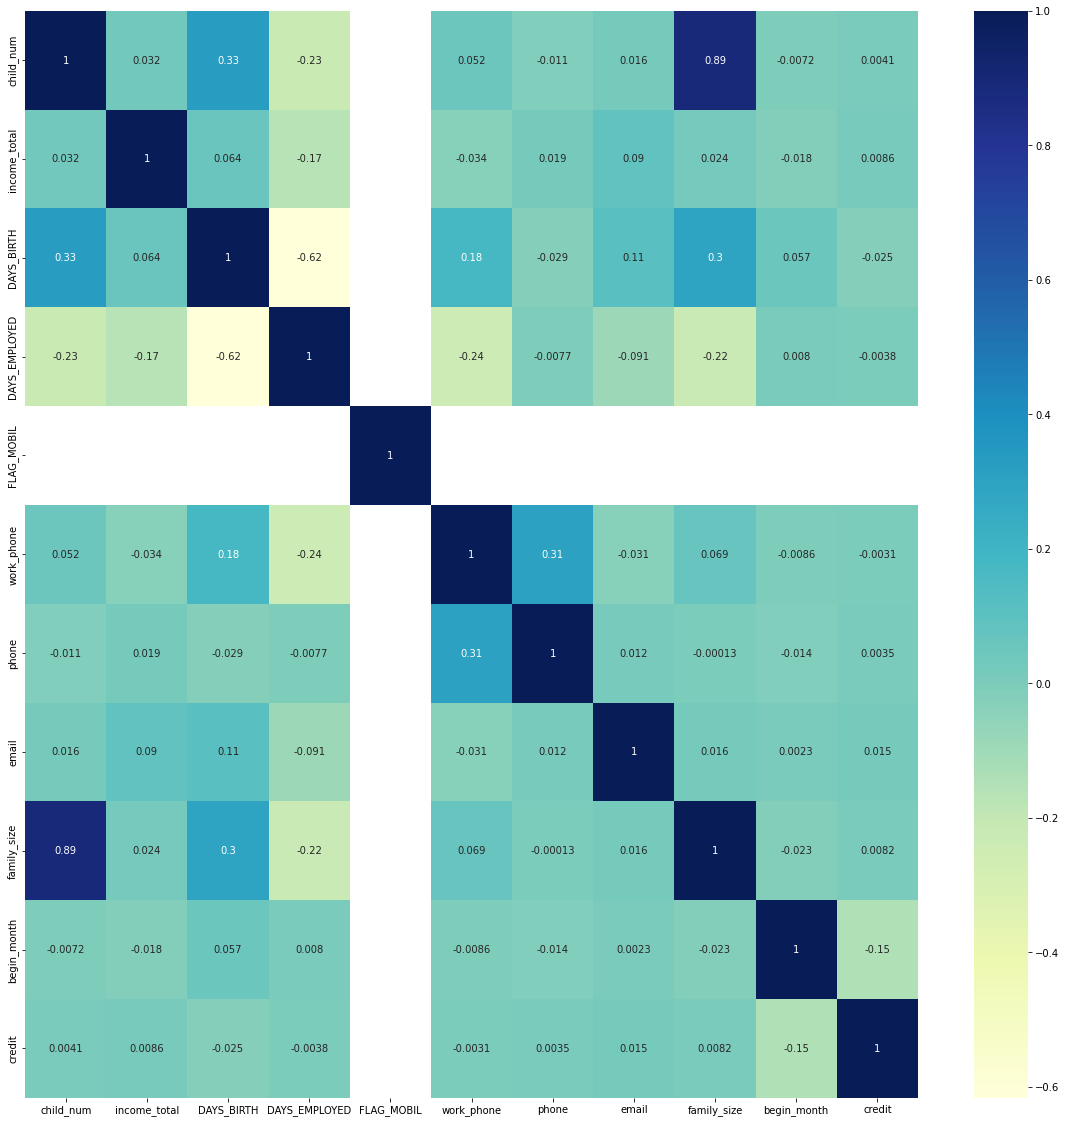

In [93]:
plt.figure(figsize=(20,20))
dataplot = sns.heatmap(co, cmap="YlGnBu", annot=True) #피어슨 상관계수

In [94]:
train['FLAG_MOBIL'].value_counts()

1    26457
Name: FLAG_MOBIL, dtype: int64

In [95]:
test['FLAG_MOBIL'].value_counts()

1    10000
Name: FLAG_MOBIL, dtype: int64

#### FLAG_MOBIL 변수에는 값이 1만 존재, 삭제 처리

In [96]:
train2 = train.drop('FLAG_MOBIL', axis=1)
train2
test2 = test.drop('FLAG_MOBIL', axis=1)
test2

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month
index,,,,,,,,,,,,,,,,,
26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,0,1,0,NaN,2.0,-60.0
26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,0,1,0,Core staff,2.0,-36.0
26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,0,Laborers,2.0,-40.0
26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,0,0,Drivers,2.0,-41.0
26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,0,0,Managers,2.0,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,0,Accountants,2.0,-19.0
36453,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,0,0,Laborers,2.0,-34.0
36454,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,0,0,0,Medicine staff,2.0,-55.0


## 5. 변수 확인

## 6. gender, car, reality, phone, work_phone, email (이진형 변수)

In [97]:
train2.value_counts(['gender'])

gender
F         17697
M          8760
dtype: int64

<AxesSubplot:xlabel='gender', ylabel='count'>

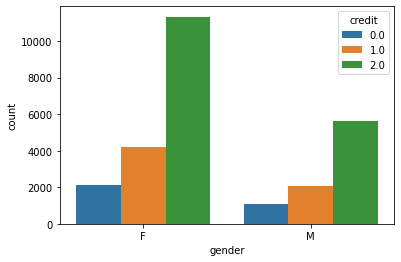

In [98]:
sns.countplot(data=train2, x='gender', hue='credit')

In [99]:
train2.value_counts(['car'])

car
N      16410
Y      10047
dtype: int64

<AxesSubplot:xlabel='car', ylabel='count'>

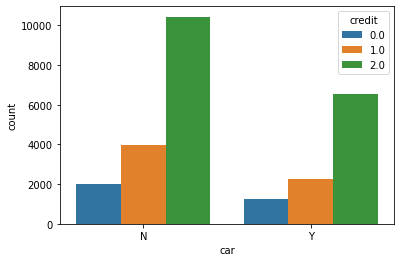

In [100]:
sns.countplot(data=train2, x='car', hue='credit')

In [101]:
train2.value_counts(['reality'])

reality
Y          17830
N           8627
dtype: int64

<AxesSubplot:xlabel='reality', ylabel='count'>

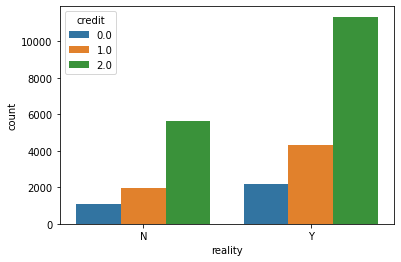

In [102]:
sns.countplot(data=train2, x='reality', hue='credit')

In [103]:
train2.value_counts(['phone'])

phone
0        18672
1         7785
dtype: int64

<AxesSubplot:xlabel='phone', ylabel='count'>

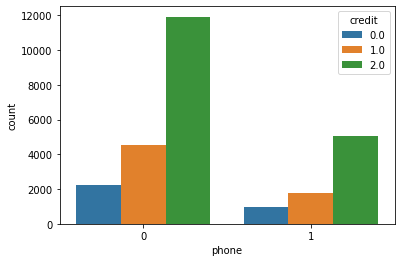

In [104]:
sns.countplot(data=train2, x='phone', hue='credit')

In [105]:
train2.value_counts(['work_phone'])

work_phone
0             20511
1              5946
dtype: int64

<AxesSubplot:xlabel='work_phone', ylabel='count'>

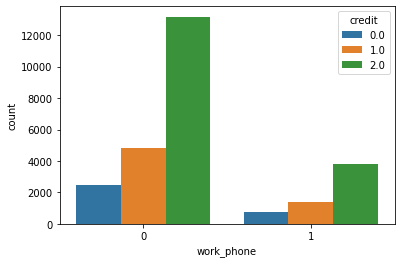

In [106]:
sns.countplot(data=train2, x='work_phone', hue='credit')

In [107]:
train2.value_counts(['email'])

email
0        24042
1         2415
dtype: int64

<AxesSubplot:xlabel='email', ylabel='count'>

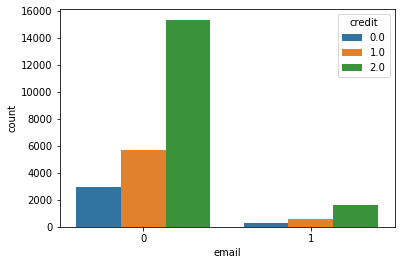

In [108]:
sns.countplot(data=train2, x='email', hue='credit')

#### 이진형 변수이므로 원핫인코딩 처리 후, 더미 변수 사용

In [109]:
train3 = pd.get_dummies(data = train2, columns = ['gender'], prefix = 'gender', drop_first = True) #남자 = 1, 여자 = 0
train4 = pd.get_dummies(data = train3, columns = ['car'], prefix = 'car', drop_first = True) #보유 =1, 미보유 = 0 
train5 = pd.get_dummies(data = train4, columns = ['reality'], prefix = 'reality', drop_first = True)
train6 = pd.get_dummies(data = train5, columns = ['phone'], prefix = 'phone', drop_first = True)
train7 = pd.get_dummies(data = train6, columns = ['email'], prefix = 'email', drop_first = True)
train8 = pd.get_dummies(data = train7, columns = ['work_phone'], prefix = 'work_phone', drop_first = True)

test3 = pd.get_dummies(data = test2, columns = ['gender'], prefix = 'gender', drop_first = True)
test4 = pd.get_dummies(data = test3, columns = ['car'], prefix = 'car', drop_first = True)
test5 = pd.get_dummies(data = test4, columns = ['reality'], prefix = 'reality', drop_first = True)
test6 = pd.get_dummies(data = test5, columns = ['phone'], prefix = 'phone', drop_first = True)
test7 = pd.get_dummies(data = test6, columns = ['email'], prefix = 'email', drop_first = True)
test8 = pd.get_dummies(data = test7, columns = ['work_phone'], prefix = 'work_phone', drop_first = True)

In [110]:
train8.iloc[:,[-6,-5,-4,-3,-2,-1]]

,gender_M,car_Y,reality_Y,phone_1,email_1,work_phone_1
index,,,,,,
0,0,0,0,0,0,0
1,0,0,1,0,1,0
2,1,1,1,1,0,0
3,0,0,1,1,0,0
4,0,1,1,0,0,0
...,...,...,...,...,...,...
26452,0,0,0,0,0,0
26453,0,0,1,0,0,0
26454,0,1,0,0,0,0


## 7. child_num

In [111]:
train8.value_counts(['child_num']).sort_index()

child_num
0            18340
1             5386
2             2362
3              306
4               47
5               10
7                2
14               3
19               1
dtype: int64

<AxesSubplot:xlabel='child_num', ylabel='count'>

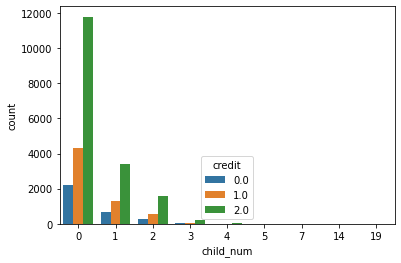

In [112]:
sns.countplot(data=train8, x='child_num', hue='credit')

## 8. income_total

In [113]:
train8.value_counts(['income_total'])

income_total
135000.0        3164
157500.0        2233
180000.0        2225
112500.0        2178
225000.0        2170
                ... 
57150.0            1
99900.0            1
531000.0           1
51750.0            1
179271.0           1
Length: 249, dtype: int64

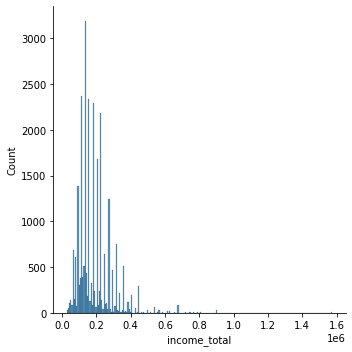

In [114]:
sns.displot(train8['income_total'])

<AxesSubplot:xlabel='income_total'>

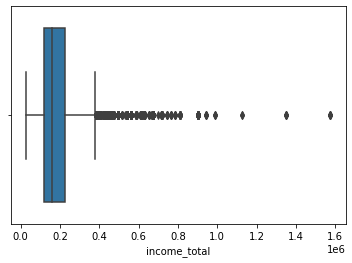

In [115]:
sns.boxplot(train8['income_total'])

<AxesSubplot:xlabel='income_total'>

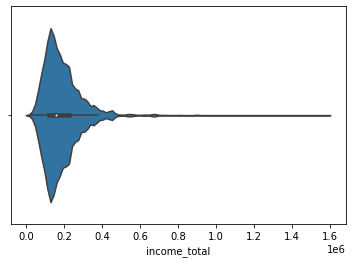

In [116]:
sns.violinplot(train8['income_total'])

#### income_total 구간화

In [117]:
count, bin_dividers =np.histogram(train5['income_total'], bins=10)
count1, bin_dividers1 =np.histogram(test5['income_total'], bins=10)

bin_names=['소득'+str(i) for i in range(10)]


train8['income_cut']=pd.cut(x=train8['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)
test8['income_cut']=pd.cut(x=test8['income_total'], bins=bin_dividers1, labels=bin_names, include_lowest=True)

train8['income_cut'] = train8['income_cut'].astype('object')
test8['income_cut'] = test8['income_cut'].astype('object')

from sklearn. preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train8['income_cut']=label_encoder.fit_transform(train8['income_cut'])
test8['income_cut']=label_encoder.fit_transform(test8['income_cut'])


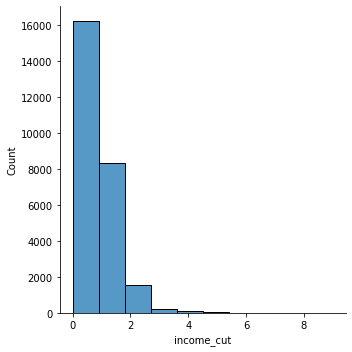

In [118]:
sns.displot(train8['income_cut'], bins=10) #총 10개의 구간으로 나눔

## 9. income_type, edu_type, family_type, house_type

In [119]:
train8.value_counts(['income_type'])

income_type         
Working                 13645
Commercial associate     6202
Pensioner                4449
State servant            2154
Student                     7
dtype: int64

<AxesSubplot:xlabel='income_type', ylabel='count'>

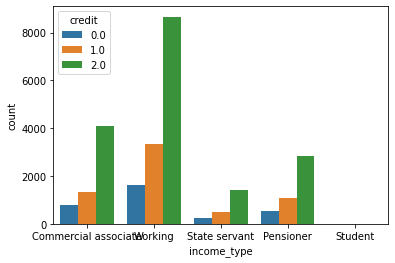

In [120]:
sns.countplot(data=train8, x='income_type', hue='credit')

In [121]:
train8.value_counts(['edu_type'])

edu_type                     
Secondary / secondary special    17995
Higher education                  7162
Incomplete higher                 1020
Lower secondary                    257
Academic degree                     23
dtype: int64

<AxesSubplot:xlabel='edu_type', ylabel='count'>

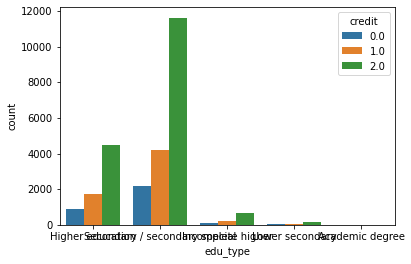

In [122]:
sns.countplot(data=train8, x='edu_type', hue='credit')

In [123]:
train8.value_counts(['family_type'])

family_type         
Married                 18196
Single / not married     3496
Civil marriage           2123
Separated                1539
Widow                    1103
dtype: int64

<AxesSubplot:xlabel='family_type', ylabel='count'>

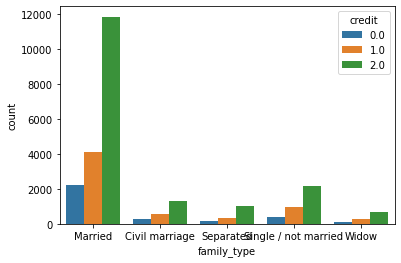

In [124]:
sns.countplot(data=train8, x='family_type', hue='credit')

In [125]:
train8.value_counts(['house_type'])

house_type         
House / apartment      23653
With parents            1257
Municipal apartment      818
Rented apartment         429
Office apartment         190
Co-op apartment          110
dtype: int64

<AxesSubplot:xlabel='house_type', ylabel='count'>

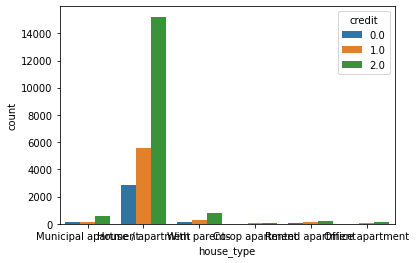

In [126]:
sns.countplot(data=train8, x='house_type', hue='credit')

#### 범주형 변수 라벨 인코딩으로 처리하여 변환

In [127]:
#인코딩
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
train8['income_type']=label_encoder.fit_transform(train8['income_type'])
test8['income_type']=label_encoder.fit_transform(test8['income_type'])

train8['edu_type']=label_encoder.fit_transform(train8['edu_type'])
test8['edu_type']=label_encoder.fit_transform(test8['edu_type'])

train8['family_type']=label_encoder.fit_transform(train8['family_type'])
test8['family_type']=label_encoder.fit_transform(test8['family_type'])

train8['house_type']=label_encoder.fit_transform(train8['house_type'])
test8['house_type']=label_encoder.fit_transform(test8['house_type'])


In [128]:
train8

,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,occyp_type,family_size,begin_month,credit,gender_M,car_Y,reality_Y,phone_1,email_1,work_phone_1,income_cut
index,,,,,,,,,,,,,,,,,,,
0,0,202500.0,0,1,1,2,-13899,-4709,NaN,2.0,-6.0,1.0,0,0,0,0,0,0,1
1,1,247500.0,0,4,0,1,-11380,-1540,Laborers,3.0,-5.0,1.0,0,0,1,0,1,0,1
2,0,450000.0,4,1,1,1,-19087,-4434,Managers,2.0,-22.0,2.0,1,1,1,1,0,0,2
3,0,202500.0,0,4,1,1,-15088,-2092,Sales staff,2.0,-37.0,0.0,0,0,1,1,0,0,1
4,0,157500.0,2,1,1,1,-15037,-2105,Managers,2.0,-26.0,2.0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,2,225000.0,2,4,1,1,-12079,-1984,Core staff,4.0,-2.0,1.0,0,0,0,0,0,0,1
26453,1,180000.0,4,1,2,1,-15291,-2475,NaN,2.0,-47.0,2.0,0,0,1,0,0,0,0
26454,0,292500.0,4,4,0,5,-10082,-2015,Core staff,2.0,-25.0,2.0,0,1,0,0,0,0,1


## 10. Occyp_type

In [129]:
train8.value_counts(['occyp_type']) # Null 값에 대한 고민이 필요

occyp_type           
Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
dtype: int64

In [130]:
train8.value_counts(['occyp_type']).sum()

18286

<AxesSubplot:xlabel='occyp_type', ylabel='count'>

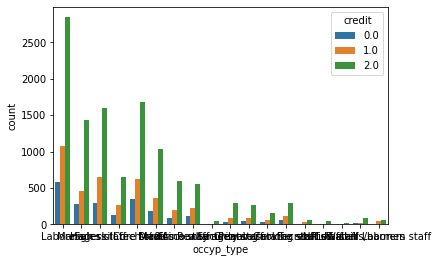

In [131]:
sns.countplot(data=train8, x='occyp_type', hue='credit')

## 11. Family Size

In [132]:
train8.value_counts(['family_size'])

family_size
2.0            14106
1.0             5109
3.0             4632
4.0             2260
5.0              291
6.0               44
7.0                9
15.0               3
9.0                2
20.0               1
dtype: int64

<AxesSubplot:xlabel='family_size', ylabel='count'>

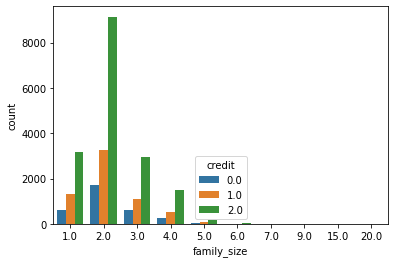

In [133]:
sns.countplot(data=train8, x='family_size', hue='credit')

## 12. begin_month, DAYS_BIRTH, DAYS_EMPLOYED

In [134]:
train8.value_counts(['begin_month']).sort_index() # 값이 음수로 되어 있음 → 양수로 변환할 필요 있음

begin_month
-60.0          235
-59.0          242
-58.0          244
-57.0          228
-56.0          254
              ... 
-4.0           557
-3.0           593
-2.0           478
-1.0           415
 0.0           231
Length: 61, dtype: int64

<AxesSubplot:xlabel='begin_month', ylabel='count'>

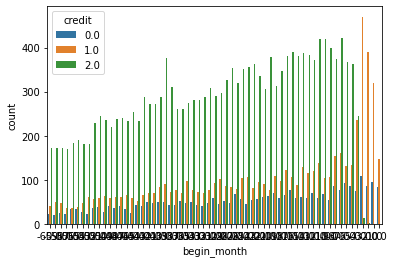

In [135]:
sns.countplot(data=train8, x='begin_month', hue='credit')

In [136]:
train8.value_counts(['DAYS_BIRTH']).sort_index() # 값이 음수로 되어 있음 → 양수로 변환할 필요 있음

DAYS_BIRTH
-25152        1
-25140        3
-25099        1
-25088        1
-24970        2
             ..
-8041         2
-7959         1
-7757         3
-7723         2
-7705         1
Length: 6621, dtype: int64

In [137]:
train8.value_counts(['DAYS_EMPLOYED']).sort_index() # 값이 음수로 되어 있음 → 양수로 변환할 필요 있음

DAYS_EMPLOYED
-15713              1
-15661              2
-15072              3
-15038             14
-14887              5
                 ... 
-70                 4
-65                 1
-43                 1
-17                 2
 365243          4438
Length: 3470, dtype: int64

#### 365243이라는 양수값은 무직자로 판단, 0으로 처리할 필요 있음

In [138]:
train8['DAYS_EMPLOYED'] = train8['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test8['DAYS_EMPLOYED'] = test8['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

In [139]:
train8.value_counts(['DAYS_EMPLOYED']).sort_index()

DAYS_EMPLOYED
-15713              1
-15661              2
-15072              3
-15038             14
-14887              5
                 ... 
-70                 4
-65                 1
-43                 1
-17                 2
 0               4438
Length: 3470, dtype: int64

In [140]:
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train8[feat]=np.abs(train8[feat])
    test8[feat]=np.abs(test8[feat]) # 음수값을 양수로 변환

In [141]:
train8

,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,occyp_type,family_size,begin_month,credit,gender_M,car_Y,reality_Y,phone_1,email_1,work_phone_1,income_cut
index,,,,,,,,,,,,,,,,,,,
0,0,202500.0,0,1,1,2,13899,4709,NaN,2.0,6.0,1.0,0,0,0,0,0,0,1
1,1,247500.0,0,4,0,1,11380,1540,Laborers,3.0,5.0,1.0,0,0,1,0,1,0,1
2,0,450000.0,4,1,1,1,19087,4434,Managers,2.0,22.0,2.0,1,1,1,1,0,0,2
3,0,202500.0,0,4,1,1,15088,2092,Sales staff,2.0,37.0,0.0,0,0,1,1,0,0,1
4,0,157500.0,2,1,1,1,15037,2105,Managers,2.0,26.0,2.0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,2,225000.0,2,4,1,1,12079,1984,Core staff,4.0,2.0,1.0,0,0,0,0,0,0,1
26453,1,180000.0,4,1,2,1,15291,2475,NaN,2.0,47.0,2.0,0,0,1,0,0,0,0
26454,0,292500.0,4,4,0,5,10082,2015,Core staff,2.0,25.0,2.0,0,1,0,0,0,0,1


## 날짜관련 파생변수

In [142]:
# DAYS_Birth_month: 태어난 월
# DAYS_Birth_week: 태어난 주(출생연도의 n주차)
train8['DAYS_BIRTH_month']=np.floor((train8['DAYS_BIRTH'])/30)-((np.floor((train8['DAYS_BIRTH'])/30)/12).astype(int)*12)
train8['DAYS_BIRTH_week']=np.floor((train8['DAYS_BIRTH'])/7)-((np.floor((train8['DAYS_BIRTH'])/7)/4).astype(int)*4)

# DAYS_EMPLOYED_month: 고용된 달
# DAYS_EMPLOYED_week: 고용된 주(고용연도의 n주차)  
train8['DAYS_EMPLOYED_month']=np.floor((train8['DAYS_EMPLOYED'])/30)-((np.floor((train8['DAYS_EMPLOYED'])/30)/12).astype(int)*12)
train8['DAYS_EMPLOYED_week']=np.floor((train8['DAYS_EMPLOYED'])/7)-((np.floor((train8['DAYS_EMPLOYED'])/7)/4).astype(int)*4)

# before_EMPLOYED: 고용되기 전까지의 일수
# before_EMPLOYED_month: 고용되기 전까지의 달
# before_EMPLOYED_month: 고용되기 전까지의 주
train8['before_EMPLOYED']=train8['DAYS_BIRTH']-train8['DAYS_EMPLOYED']
train8['before_EMPLOYED_month']=np.floor((train8['before_EMPLOYED'])/30)-((np.floor((train8['before_EMPLOYED'])/30)/12).astype(int)*12)
train8['before_EMPLOYED_week']=np.floor((train8['before_EMPLOYED'])/7)-((np.floor((train8['before_EMPLOYED'])/7)/4).astype(int)*4)





# DAYS_Birth_month: 태어난 월
# DAYS_Birth_week: 태어난 주(출생연도의 n주차)
test8['DAYS_BIRTH_month']=np.floor((test8['DAYS_BIRTH'])/30)-((np.floor((test8['DAYS_BIRTH'])/30)/12).astype(int)*12)
test8['DAYS_BIRTH_week']=np.floor((test8['DAYS_BIRTH'])/7)-((np.floor((test8['DAYS_BIRTH'])/7)/4).astype(int)*4)

# DAYS_EMPLOYED_month: 고용된 달
# DAYS_EMPLOYED_week: 고용된 주(고용연도의 n주차)  
test8['DAYS_EMPLOYED_month']=np.floor((test8['DAYS_EMPLOYED'])/30)-((np.floor((test8['DAYS_EMPLOYED'])/30)/12).astype(int)*12)
test8['DAYS_EMPLOYED_week']=np.floor((test8['DAYS_EMPLOYED'])/7)-((np.floor((test8['DAYS_EMPLOYED'])/7)/4).astype(int)*4)

# before_EMPLOYED: 고용되기 전까지의 일수
# before_EMPLOYED_month: 고용되기 전까지의 달
# before_EMPLOYED_month: 고용되기 전까지의 주
test8['before_EMPLOYED']=test8['DAYS_BIRTH']-test8['DAYS_EMPLOYED']
test8['before_EMPLOYED_month']=np.floor((test8['before_EMPLOYED'])/30)-((np.floor((test8['before_EMPLOYED'])/30)/12).astype(int)*12)
test8['before_EMPLOYED_week']=np.floor((test8['before_EMPLOYED'])/7)-((np.floor((test8['before_EMPLOYED'])/7)/4).astype(int)*4)



In [143]:
train8

,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,occyp_type,family_size,begin_month,credit,gender_M,car_Y,reality_Y,phone_1,email_1,work_phone_1,income_cut,DAYS_BIRTH_month,DAYS_BIRTH_week,DAYS_EMPLOYED_month,DAYS_EMPLOYED_week,before_EMPLOYED,before_EMPLOYED_month,before_EMPLOYED_week
index,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,202500.0,0,1,1,2,13899,4709,NaN,2.0,6.0,1.0,0,0,0,0,0,0,1,7.0,1.0,0.0,0.0,9190,6.0,0.0
1,1,247500.0,0,4,0,1,11380,1540,Laborers,3.0,5.0,1.0,0,0,1,0,1,0,1,7.0,1.0,3.0,0.0,9840,4.0,1.0
2,0,450000.0,4,1,1,1,19087,4434,Managers,2.0,22.0,2.0,1,1,1,1,0,0,2,0.0,2.0,3.0,1.0,14653,8.0,1.0
3,0,202500.0,0,4,1,1,15088,2092,Sales staff,2.0,37.0,0.0,0,0,1,1,0,0,1,10.0,3.0,9.0,2.0,12996,1.0,0.0
4,0,157500.0,2,1,1,1,15037,2105,Managers,2.0,26.0,2.0,0,1,1,0,0,0,0,9.0,0.0,10.0,0.0,12932,11.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,2,225000.0,2,4,1,1,12079,1984,Core staff,4.0,2.0,1.0,0,0,0,0,0,0,1,6.0,1.0,6.0,3.0,10095,0.0,2.0
26453,1,180000.0,4,1,2,1,15291,2475,NaN,2.0,47.0,2.0,0,0,1,0,0,0,0,5.0,0.0,10.0,1.0,12816,7.0,2.0
26454,0,292500.0,4,4,0,5,10082,2015,Core staff,2.0,25.0,2.0,0,1,0,0,0,0,1,0.0,0.0,7.0,3.0,8067,4.0,0.0


In [144]:
test8

,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,occyp_type,family_size,begin_month,gender_M,car_Y,reality_Y,phone_1,email_1,work_phone_1,income_cut,DAYS_BIRTH_month,DAYS_BIRTH_week,DAYS_EMPLOYED_month,DAYS_EMPLOYED_week,before_EMPLOYED,before_EMPLOYED_month,before_EMPLOYED_week
index,,,,,,,,,,,,,,,,,,,,,,,,,
26457,0,112500.0,1,4,0,1,21990,0,NaN,2.0,60.0,1,1,0,1,0,0,0,1.0,1.0,0.0,0.0,21990,1.0,1.0
26458,0,135000.0,2,1,1,1,18964,8671,Core staff,2.0,36.0,0,0,1,1,0,0,0,8.0,1.0,1.0,2.0,10293,7.0,2.0
26459,0,69372.0,4,4,1,1,15887,217,Laborers,2.0,40.0,0,0,1,1,0,1,0,1.0,1.0,7.0,3.0,15670,6.0,2.0
26460,0,112500.0,0,4,1,1,19270,2531,Drivers,2.0,41.0,1,1,0,0,0,1,0,6.0,0.0,0.0,1.0,16739,5.0,3.0
26461,0,225000.0,2,1,1,1,17822,9385,Managers,2.0,8.0,0,1,1,0,0,1,1,6.0,2.0,0.0,0.0,8437,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,0,202500.0,4,2,1,1,18593,5434,Accountants,2.0,19.0,0,1,1,1,0,1,1,7.0,0.0,1.0,0.0,13159,6.0,3.0
36453,0,202500.0,4,4,0,1,10886,1315,Laborers,2.0,34.0,1,1,1,0,0,1,1,2.0,3.0,7.0,3.0,9571,7.0,3.0
36454,0,292500.0,4,4,1,1,21016,14018,Medicine staff,2.0,55.0,0,0,1,0,0,0,1,4.0,2.0,11.0,2.0,6998,5.0,3.0


#### 근무기간이 존재하는데, 직업 타입이 없는 경우 = unknown으로 처리
#### 근무기간이 존재하지 않고, 직업 타입도 없는 경우 = No job으로 처리

In [146]:
train8.loc[train8['DAYS_EMPLOYED']==0,['occyp_type']] = 'No Job'
train8 = train8.fillna({'occyp_type':'unknown'})

test8.loc[test8['DAYS_EMPLOYED']==0,['occyp_type']] = 'No Job'
test8 = test8.fillna({'occyp_type':'unknown'})

#### 빈도수가 적은 카테고리 = staff와 specialist로 묶기

In [147]:
train8.loc[train8['occyp_type'] == 'High skill tech staff', 'occyp_type'] = 'specialist'
train8.loc[train8['occyp_type'] == 'Medicine staff', 'occyp_type'] = 'specialist'
train8.loc[train8['occyp_type'] == 'Accountants', 'occyp_type'] = 'specialist'

test8.loc[test8['occyp_type'] == 'High skill tech staff', 'occyp_type'] = 'specialist'
test8.loc[test8['occyp_type'] == 'Medicine staff', 'occyp_type'] = 'specialist'
test8.loc[test8['occyp_type'] == 'Accountants', 'occyp_type'] = 'specialist'

In [148]:
train8.loc[train8['occyp_type'] == 'Cooking staff', 'occyp_type'] = 'staff'
train8.loc[train8['occyp_type'] == 'Security staff', 'occyp_type'] = 'staff'
train8.loc[train8['occyp_type'] == 'Cleaning staff', 'occyp_type'] = 'staff'
train8.loc[train8['occyp_type'] == 'Private service staff', 'occyp_type'] = 'staff'
train8.loc[train8['occyp_type'] == 'Low-skill Laborers', 'occyp_type'] = 'staff'
train8.loc[train8['occyp_type'] == 'Waiters/barmen staff', 'occyp_type'] = 'staff'
train8.loc[train8['occyp_type'] == 'Secretaries', 'occyp_type'] = 'staff'
train8.loc[train8['occyp_type'] == 'Realty agents', 'occyp_type'] = 'staff'
train8.loc[train8['occyp_type'] == 'HR staff', 'occyp_type'] = 'staff'
train8.loc[train8['occyp_type'] == 'IT staff', 'occyp_type'] = 'staff'


test8.loc[test8['occyp_type'] == 'Cooking staff', 'occyp_type'] = 'staff'
test8.loc[test8['occyp_type'] == 'Security staff', 'occyp_type'] = 'staff'
test8.loc[test8['occyp_type'] == 'Cleaning staff', 'occyp_type'] = 'staff'
test8.loc[test8['occyp_type'] == 'Private service staff', 'occyp_type'] = 'staff'
test8.loc[test8['occyp_type'] == 'Low-skill Laborers', 'occyp_type'] = 'staff'
test8.loc[test8['occyp_type'] == 'Waiters/barmen staff', 'occyp_type'] = 'staff'
test8.loc[test8['occyp_type'] == 'Secretaries', 'occyp_type'] = 'staff'
test8.loc[test8['occyp_type'] == 'Realty agents', 'occyp_type'] = 'staff'
test8.loc[test8['occyp_type'] == 'HR staff', 'occyp_type'] = 'staff'
test8.loc[test8['occyp_type'] == 'IT staff', 'occyp_type'] = 'staff'

In [149]:
pd.set_option('display.max_columns', None) 
train8

,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,occyp_type,family_size,begin_month,credit,gender_M,car_Y,reality_Y,phone_1,email_1,work_phone_1,income_cut,DAYS_BIRTH_month,DAYS_BIRTH_week,DAYS_EMPLOYED_month,DAYS_EMPLOYED_week,before_EMPLOYED,before_EMPLOYED_month,before_EMPLOYED_week
index,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,202500.0,0,1,1,2,13899,4709,unknown,2.0,6.0,1.0,0,0,0,0,0,0,1,7.0,1.0,0.0,0.0,9190,6.0,0.0
1,1,247500.0,0,4,0,1,11380,1540,Laborers,3.0,5.0,1.0,0,0,1,0,1,0,1,7.0,1.0,3.0,0.0,9840,4.0,1.0
2,0,450000.0,4,1,1,1,19087,4434,Managers,2.0,22.0,2.0,1,1,1,1,0,0,2,0.0,2.0,3.0,1.0,14653,8.0,1.0
3,0,202500.0,0,4,1,1,15088,2092,Sales staff,2.0,37.0,0.0,0,0,1,1,0,0,1,10.0,3.0,9.0,2.0,12996,1.0,0.0
4,0,157500.0,2,1,1,1,15037,2105,Managers,2.0,26.0,2.0,0,1,1,0,0,0,0,9.0,0.0,10.0,0.0,12932,11.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,2,225000.0,2,4,1,1,12079,1984,Core staff,4.0,2.0,1.0,0,0,0,0,0,0,1,6.0,1.0,6.0,3.0,10095,0.0,2.0
26453,1,180000.0,4,1,2,1,15291,2475,unknown,2.0,47.0,2.0,0,0,1,0,0,0,0,5.0,0.0,10.0,1.0,12816,7.0,2.0
26454,0,292500.0,4,4,0,5,10082,2015,Core staff,2.0,25.0,2.0,0,1,0,0,0,0,1,0.0,0.0,7.0,3.0,8067,4.0,0.0


In [150]:
test8

,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,occyp_type,family_size,begin_month,gender_M,car_Y,reality_Y,phone_1,email_1,work_phone_1,income_cut,DAYS_BIRTH_month,DAYS_BIRTH_week,DAYS_EMPLOYED_month,DAYS_EMPLOYED_week,before_EMPLOYED,before_EMPLOYED_month,before_EMPLOYED_week
index,,,,,,,,,,,,,,,,,,,,,,,,,
26457,0,112500.0,1,4,0,1,21990,0,No Job,2.0,60.0,1,1,0,1,0,0,0,1.0,1.0,0.0,0.0,21990,1.0,1.0
26458,0,135000.0,2,1,1,1,18964,8671,Core staff,2.0,36.0,0,0,1,1,0,0,0,8.0,1.0,1.0,2.0,10293,7.0,2.0
26459,0,69372.0,4,4,1,1,15887,217,Laborers,2.0,40.0,0,0,1,1,0,1,0,1.0,1.0,7.0,3.0,15670,6.0,2.0
26460,0,112500.0,0,4,1,1,19270,2531,Drivers,2.0,41.0,1,1,0,0,0,1,0,6.0,0.0,0.0,1.0,16739,5.0,3.0
26461,0,225000.0,2,1,1,1,17822,9385,Managers,2.0,8.0,0,1,1,0,0,1,1,6.0,2.0,0.0,0.0,8437,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,0,202500.0,4,2,1,1,18593,5434,specialist,2.0,19.0,0,1,1,1,0,1,1,7.0,0.0,1.0,0.0,13159,6.0,3.0
36453,0,202500.0,4,4,0,1,10886,1315,Laborers,2.0,34.0,1,1,1,0,0,1,1,2.0,3.0,7.0,3.0,9571,7.0,3.0
36454,0,292500.0,4,4,1,1,21016,14018,specialist,2.0,55.0,0,0,1,0,0,0,1,4.0,2.0,11.0,2.0,6998,5.0,3.0


In [151]:
train8.value_counts(['occyp_type'])

occyp_type 
Laborers       4512
No Job         4438
unknown        3733
specialist     2806
Core staff     2646
Sales staff    2539
Managers       2167
staff          2041
Drivers        1575
dtype: int64

In [152]:
train8['occyp_type']=label_encoder.fit_transform(train8['occyp_type'])
test8['occyp_type']=label_encoder.fit_transform(test8['occyp_type'])

## 연속형 변수 표준화

In [153]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train8.loc[:,['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']] = scaler.fit_transform(train8.loc[:,['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']])
test8.loc[:,['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']] = scaler.fit_transform(test8.loc[:,['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']])


In [154]:
pd.set_option('display.max_columns', None) 
train8

,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,occyp_type,family_size,begin_month,credit,gender_M,car_Y,reality_Y,phone_1,email_1,work_phone_1,income_cut,DAYS_BIRTH_month,DAYS_BIRTH_week,DAYS_EMPLOYED_month,DAYS_EMPLOYED_week,before_EMPLOYED,before_EMPLOYED_month,before_EMPLOYED_week
index,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0.149136,0,1,1,2,-0.490075,1.059227,8,2.0,-1.215231,1.0,0,0,0,0,0,0,1,7.0,1.0,0.0,0.0,9190,6.0,0.0
1,1,0.590848,0,4,0,1,-1.089621,-0.277849,2,3.0,-1.275620,1.0,0,0,1,0,1,0,1,7.0,1.0,3.0,0.0,9840,4.0,1.0
2,0,2.578550,4,1,1,1,0.744719,0.943198,3,2.0,-0.249003,2.0,1,1,1,1,0,0,2,0.0,2.0,3.0,1.0,14653,8.0,1.0
3,0,0.149136,0,4,1,1,-0.207081,-0.044947,5,2.0,0.656836,0.0,0,0,1,1,0,0,1,10.0,3.0,9.0,2.0,12996,1.0,0.0
4,0,-0.292575,2,1,1,1,-0.219220,-0.039462,3,2.0,-0.007446,2.0,0,1,1,0,0,0,0,9.0,0.0,10.0,0.0,12932,11.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,2,0.369992,2,4,1,1,-0.923252,-0.090515,0,4.0,-1.456788,1.0,0,0,0,0,0,0,1,6.0,1.0,6.0,3.0,10095,0.0,2.0
26453,1,-0.071719,4,1,2,1,-0.158765,0.116649,8,2.0,1.260729,2.0,0,0,1,0,0,0,0,5.0,0.0,10.0,1.0,12816,7.0,2.0
26454,0,1.032559,4,4,0,5,-1.398558,-0.077435,0,2.0,-0.067835,2.0,0,1,0,0,0,0,1,0.0,0.0,7.0,3.0,8067,4.0,0.0


In [155]:
co2 = train8.corr(method=pearsonr_co)

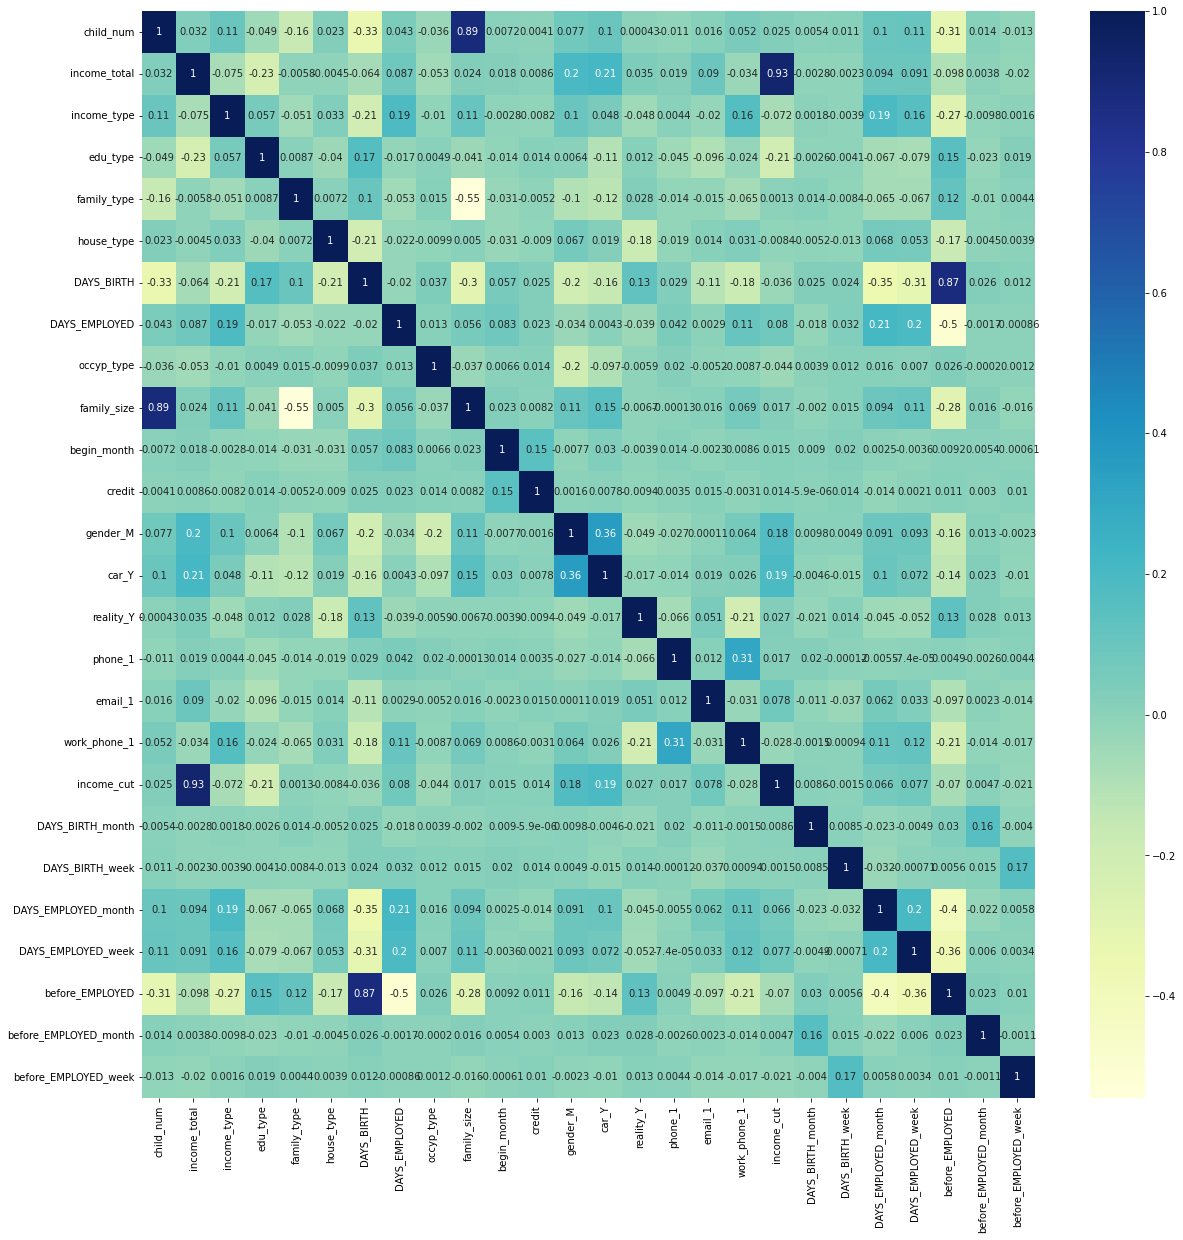

In [156]:
plt.figure(figsize=(20,20))
dataplot = sns.heatmap(co2, cmap="YlGnBu", annot=True) #피어슨 상관계수

In [157]:
#파생변수와 다중공선성을 보이는 칼럼 삭제
cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED',]
train8.drop(cols, axis=1, inplace=True)
test8.drop(cols, axis=1, inplace=True)

In [166]:
#train8.to_csv('newcard_train.csv', sep=',')
#test8.to_csv('newcard_test.csv', sep=',')

In [158]:
! pip install pycaret

In [159]:
from pycaret.classification import *
from sklearn.metrics import log_loss

In [160]:
clf = setup(train8, target = 'credit', train_size = 0.8)
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

,Description,Value
0,session_id,1125
1,Target,credit
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(26457, 23)"
5,Missing Values,False
6,Numeric Features,22
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


Name                                                           LogLoss
Display Name                                                   LogLoss
Score Function               <function log_loss at 0x000001E15F771700>
Scorer               make_scorer(log_loss, greater_is_better=False,...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: logloss, dtype: object

In [161]:
best10 = compare_models(fold = 10, sort = 'logloss', n_select = 5, exclude=['svm','ridge'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,TT (Sec)
catboost,CatBoost Classifier,0.7089,0.7350,0.4662,0.6937,0.6539,0.3006,0.3556,0.7395,11.8430
xgboost,Extreme Gradient Boosting,0.7064,0.7304,0.4655,0.6879,0.6518,0.2952,0.3490,0.7451,5.8170
lightgbm,Light Gradient Boosting Machine,0.7025,0.7236,0.4353,0.7091,0.6299,0.2545,0.3362,0.7505,0.6290
gbc,Gradient Boosting Classifier,0.6919,0.6569,0.4099,0.6575,0.6065,0.2110,0.3032,0.7945,5.1700
lda,Linear Discriminant Analysis,0.6416,0.6069,0.3346,0.5775,0.5025,0.0039,0.0366,0.8631,0.0750
qda,Quadratic Discriminant Analysis,0.6429,0.6031,0.3647,0.5508,0.5510,0.0863,0.1237,0.8816,0.0420
lr,Logistic Regression,0.6406,0.5271,0.3334,0.4184,0.5004,0.0000,0.0003,0.8837,1.0230
nb,Naive Bayes,0.6419,0.5954,0.3576,0.5247,0.5420,0.0680,0.1068,0.8859,0.0330
rf,Random Forest Classifier,0.7004,0.7545,0.5487,0.6817,0.6867,0.3798,0.3846,0.9711,1.7070
ada,Ada Boost Classifier,0.6904,0.6252,0.4049,0.6317,0.6016,0.2009,0.2999,1.0783,0.5210


In [162]:
from pycaret.datasets import get_data
X_test = get_config('X_test')
X_train = get_config('X_train')
Y_test = get_config('y_test')
Y_train = get_config('y_train')

test_x = get_config('X_test')
train_x = get_config('X_train')
test_y = get_config('y_test')
train_y = get_config('y_train')

x_test = get_config('X_test')
x_train = get_config('X_train')
y_test = get_config('y_test')
y_train = get_config('y_train')

validation_y = get_config('y_test')
y_validation = get_config('y_test')
validation_Y = get_config('y_test')
Y_validation = get_config('y_test')

In [163]:
model_cat = create_model("catboost")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.7109,0.7352,0.4725,0.7101,0.6572,0.3044,0.3616,0.7337
1,0.7029,0.7333,0.4574,0.6776,0.6463,0.2877,0.3387,0.7428
2,0.7156,0.7479,0.4808,0.6998,0.6660,0.3276,0.3756,0.7272
3,0.6972,0.7285,0.4511,0.6802,0.6384,0.2651,0.3216,0.7527
4,0.7038,0.7361,0.4571,0.6731,0.6473,0.2903,0.3416,0.7390
5,0.7122,0.7392,0.4693,0.6949,0.6581,0.3112,0.3644,0.7364
6,0.7112,0.7336,0.4680,0.6934,0.6568,0.3087,0.3617,0.7411
7,0.7079,0.7295,0.4609,0.6901,0.6507,0.2947,0.3522,0.7451
8,0.7112,0.7378,0.4699,0.7007,0.6570,0.3041,0.3625,0.7416
9,0.7160,0.7290,0.4754,0.7177,0.6614,0.3125,0.3762,0.7356


In [164]:
tuned_cat = tune_model(model_cat)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.7156,0.7531,0.5335,0.6941,0.6899,0.3762,0.3941,0.7523
1,0.7005,0.7400,0.5098,0.6721,0.6725,0.3434,0.3594,0.7872
2,0.7133,0.7558,0.5352,0.6885,0.6909,0.3842,0.3960,0.7681
3,0.6963,0.7290,0.5122,0.6694,0.6712,0.3400,0.3537,0.8068
4,0.7100,0.7475,0.5255,0.6872,0.6834,0.3634,0.3806,0.7740
5,0.7112,0.7562,0.5248,0.6835,0.6864,0.3753,0.3885,0.7653
6,0.7122,0.7415,0.5219,0.6856,0.6850,0.3704,0.3864,0.7838
7,0.7150,0.7386,0.5239,0.6906,0.6869,0.3715,0.3903,0.7771
8,0.7084,0.7468,0.5305,0.6860,0.6843,0.3648,0.3798,0.7767
9,0.7164,0.7506,0.5297,0.6948,0.6890,0.3731,0.3936,0.7473


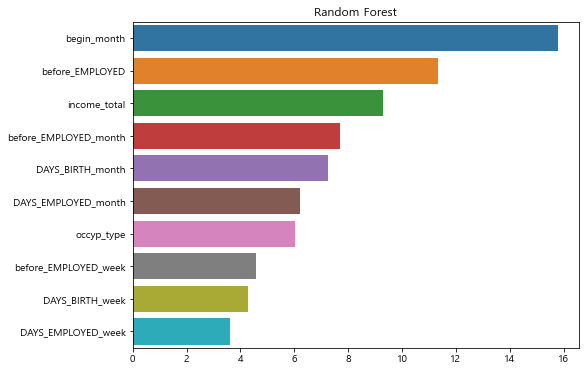

In [165]:
ft_importance_values = model_cat.feature_importances_
plt.rcParams['font.family'] = 'Malgun Gothic'
ft_series = pd.Series(ft_importance_values, index = X_train.columns)
ft_top10 = ft_series.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
sns.barplot(x=ft_top10, y=ft_top10.index)
plt.title('Random Forest')
plt.show()
plt.rcParams['font.family'] = 'Malgun Gothic'

In [ ]:
train8.loc[:,'child_num':]

In [ ]:
train8.loc[:,'credit']

In [548]:
train_x=train8.drop('credit', axis=1)
train_y=train8[['credit']]
test_x=test8

In [549]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

In [550]:
xgb_wrapper = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1,  monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=4100, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0)
evals = [(X_val, y_val)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="mlogloss", 
                eval_set=evals, verbose=True)

preds = xgb_wrapper.predict(X_val)
pred_proba = xgb_wrapper.predict_proba(X_val)

[0]	validation_0-mlogloss:0.97929
[1]	validation_0-mlogloss:0.91089
[2]	validation_0-mlogloss:0.86995
[3]	validation_0-mlogloss:0.84522
[4]	validation_0-mlogloss:0.83005
[5]	validation_0-mlogloss:0.81990
[6]	validation_0-mlogloss:0.81351
[7]	validation_0-mlogloss:0.80942
[8]	validation_0-mlogloss:0.80595
[9]	validation_0-mlogloss:0.80375
[10]	validation_0-mlogloss:0.80247
[11]	validation_0-mlogloss:0.80143
[12]	validation_0-mlogloss:0.79962
[13]	validation_0-mlogloss:0.79755
[14]	validation_0-mlogloss:0.79567
[15]	validation_0-mlogloss:0.79328
[16]	validation_0-mlogloss:0.79177
[17]	validation_0-mlogloss:0.79017
[18]	validation_0-mlogloss:0.78938
[19]	validation_0-mlogloss:0.78754
[20]	validation_0-mlogloss:0.78532
[21]	validation_0-mlogloss:0.78389
[22]	validation_0-mlogloss:0.78279
[23]	validation_0-mlogloss:0.78121
[24]	validation_0-mlogloss:0.78023
[25]	validation_0-mlogloss:0.77831
[26]	validation_0-mlogloss:0.77738
[27]	validation_0-mlogloss:0.77698
[28]	validation_0-mlogloss:0.7

In [551]:
pred_proba

array([[0.05802513, 0.17045005, 0.7715248 ],
       [0.02609445, 0.23641336, 0.7374922 ],
       [0.03316774, 0.06898374, 0.89784855],
       ...,
       [0.02835355, 0.0827679 , 0.8888785 ],
       [0.03509035, 0.46503454, 0.4998751 ],
       [0.04679337, 0.27889276, 0.6743139 ]], dtype=float32)

In [89]:
sub = pd.read_csv(path +'/sample_submission.csv')